In [1]:
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Splits training and testing data then gets corresponding files based on similar file names
dataset_path = "../../../Project/Dataset/Night/"

validation_rgb = list(Path(dataset_path + 'RGB/Night_Validation').glob('*.png'))
validation_annotated = list(Path(dataset_path + 'Annotated/Validation').glob('*_gt_labelColor.png'))

# Splits training and testing data then gets corresponding files based on similar file names
training_rgb, test_rgb = train_test_split(list(Path(dataset_path + 'RGB/Night_Train').glob('*.png')), test_size=0.1)
training_annotated = [y for x in training_rgb for y in
                      list(Path(dataset_path + 'Annotated/Train').glob('*_gt_labelColor.png'))
                      if x.name.strip('_rgb_anon.png') == y.name.strip('_gt_labelColor.png')]
test_annotated = [y for x in test_rgb for y in list(Path(dataset_path + 'Annotated/Train').glob('*_gt_labelColor.png'))
                  if x.name.strip('_rgb_anon.png') == y.name.strip('_gt_labelColor.png')]

In [3]:
# [(image, annotated image)]
training_duo = [(x, y) for x, y in zip(training_rgb, training_annotated)]
testing_duo = [(x, y) for x, y in zip(test_rgb, test_annotated)]
validation_duo = [(x, y) for x, y in zip(validation_rgb, validation_annotated)]
image_size = (256, 256)

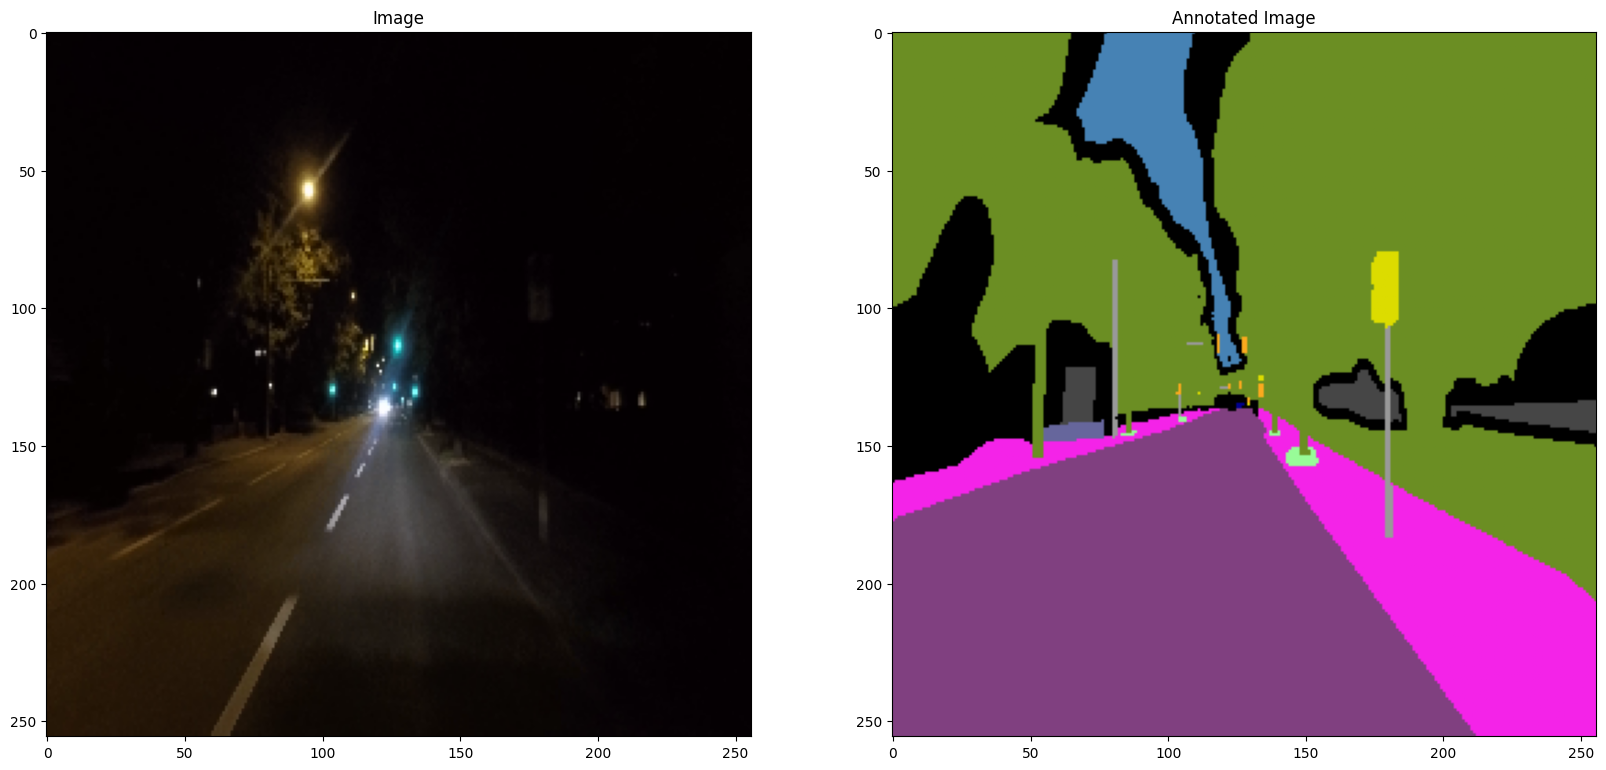

In [4]:
random_duo = training_duo[0]
image = img_to_array(load_img(random_duo[0], target_size=image_size))
annotated_image = img_to_array(load_img(random_duo[1], target_size =image_size))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(20)
fig.set_figwidth(20)
ax1.set_title('Image')
ax1.imshow(image / 255.)
ax2.set_title('Annotated Image')
ax2.imshow(annotated_image / 255.)

In [5]:
image_size = (256, 256)
classes_df = pd.read_csv("class_dict.csv")
classes = []
for index, item in classes_df.iterrows():
    classes.append(np.array([item['r'], item['g'], item['b']]))
num_classes = len(classes)

In [6]:
# Converts annotations from RGB to 2D -> Array of size image_size x image_size which contains each pixel -> Each pixel will hold a class value
def form_2D_label(mask,class_map):
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    return label

In [7]:
# Converts annotations from RGB to 2D -> Array of size image_size x image_size which contains each pixel -> Each pixel will hold a class value
def rgb_to_2D_classes(annotated, class_map):
    label = np.zeros(annotated.shape[:2], dtype=np.uint8)
    for i, rgb in enumerate(class_map):
        label[(annotated == rgb).all(axis=2)] = i
    return label


# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
class DataGenerator(Sequence):
    'Generates data for Keras'

    def __init__(self, duo, classes, n_classes, batch_size=2, dim=(128, 128), shuffle=True):
        'Initialization'
        self.dim = dim
        self.duo = duo
        self.classes = classes
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.duo) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.duo))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
        # Initialization
        X = []
        y = []

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.duo[i][0], target_size=self.dim)
            img = img_to_array(img) / 255. # Image to numpy array -> /255 to get array values between 0 and 1
            X.append(img)

            label = load_img(self.duo[i][1], target_size=self.dim)
            label = img_to_array(label)
            label = rgb_to_2D_classes(label, self.classes)
            label = to_categorical(label, num_classes=self.n_classes) # Converts to binary class matrix
            y.append(label)

        return np.array(X), np.array(y)

In [8]:
class UNet:
    def __init__(self, dimensions, channels, filters, n_classes):
        input_layer = Input(shape=(dimensions + (channels,)), name='input')

        conv_1_layer = self.__gen_convolution(input_layer, filters)
        conv_1_pooling = MaxPooling2D(pool_size=(2, 2))(conv_1_layer)

        conv_2_layer = self.__gen_convolution(conv_1_pooling, filters * 2)
        conv_2_pooling = MaxPooling2D(pool_size=(2, 2))(conv_2_layer)

        conv_3_layer = self.__gen_convolution(conv_2_pooling, filters * 4)
        conv_3_pooling = MaxPooling2D(pool_size=(2, 2))(conv_3_layer)

        conv_4_layer = self.__gen_convolution(conv_3_pooling, filters * 8)
        conv_4_pooling = MaxPooling2D(pool_size=(2, 2))(conv_4_layer)
        conv_4_dropout = Dropout(0.5)(conv_4_pooling)

        conv_5_layer = self.__gen_convolution(conv_4_dropout, filters * 16)
        conv_5_dropout = Dropout(0.5)(conv_5_layer)

        deconv_6_layer = self.__gen_deconvolution(conv_5_dropout, filters * 8, conv_4_layer)
        deconv_6_dropout = Dropout(0.5)(deconv_6_layer)

        deconv_7_layer = self.__gen_deconvolution(deconv_6_dropout, filters * 4, conv_3_layer)
        deconv_7_dropout = Dropout(0.5)(deconv_7_layer)

        deconv_8_layer = self.__gen_deconvolution(deconv_7_dropout, filters * 2, conv_2_layer)
        deconv_9_layer = self.__gen_deconvolution(deconv_8_layer, filters * 2, conv_1_layer)
        output_layer = Conv2D(filters=n_classes, kernel_size=(1, 1), activation='softmax')(deconv_9_layer)

        self.model = Model(inputs=input_layer, outputs=output_layer, name='UNet')

    def __gen_convolution(self, prev, filters):
        temp = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal',
                         activation='relu')(prev)
        temp = BatchNormalization()(temp)
        temp = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal',
                         activation='relu')(temp)
        return BatchNormalization()(temp)

    def __gen_deconvolution(self, prev, filters, residual):
        temp = Conv2DTranspose(filters=filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(prev)
        temp = concatenate([temp, residual], axis=3)
        return self.__gen_convolution(temp, filters)

In [9]:
model = UNet(image_size, 3, 64, num_classes).model

In [10]:
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 512)  2359808     ['batch_normalization_10[0][0]'] 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 32, 32, 512)  2048       ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_2 (Dropout)            (None, 32, 32, 512)  0           ['batch_normalization_11[0][0]'] 
          

In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])
# To load previously trained model
# model.load_weights('./fog-weights.h5')

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard

my_callbacks = [
    CSVLogger("./models/UNet/logs/log.csv", separator=",", append=False),
    ModelCheckpoint(filepath='./models/UNet/night-weights.h5', save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
    TensorBoard(log_dir='./models/UNet/logs')
]

In [13]:
training_data = DataGenerator(training_duo+testing_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True)
training_steps = training_data.__len__()

In [14]:
validation_data = DataGenerator(validation_duo,classes,num_classes,batch_size=3, dim=image_size ,shuffle=True)
validation_steps = validation_data.__len__()

In [15]:
model_train = model.fit(training_data, epochs=100, callbacks=my_callbacks, validation_data=validation_data, steps_per_epoch=training_steps, validation_steps=validation_steps)

Epoch 1/100
133/133 [==============================] - 72s 479ms/step - loss: 1.6095 - accuracy: 0.5318 - val_loss: 60.6362 - val_accuracy: 0.1272
Epoch 2/100
133/133 [==============================] - 44s 326ms/step - loss: 1.2036 - accuracy: 0.5999 - val_loss: 11.0432 - val_accuracy: 0.3352
Epoch 3/100
133/133 [==============================] - 43s 322ms/step - loss: 1.1147 - accuracy: 0.6168 - val_loss: 2.3399 - val_accuracy: 0.4533
Epoch 4/100
133/133 [==============================] - 43s 319ms/step - loss: 1.0609 - accuracy: 0.6330 - val_loss: 1.3726 - val_accuracy: 0.5939
Epoch 5/100
133/133 [==============================] - 42s 315ms/step - loss: 1.0158 - accuracy: 0.6417 - val_loss: 1.3451 - val_accuracy: 0.5932
Epoch 6/100
133/133 [==============================] - 43s 322ms/step - loss: 0.9974 - accuracy: 0.6480 - val_loss: 1.2619 - val_accuracy: 0.6169
Epoch 7/100
133/133 [==============================] - 42s 316ms/step - loss: 0.9609 - accuracy: 0.6625 - val_loss: 1.4103

Epoch 57/100
133/133 [==============================] - 46s 344ms/step - loss: 0.3089 - accuracy: 0.8905 - val_loss: 0.9779 - val_accuracy: 0.7331
Epoch 58/100
133/133 [==============================] - 43s 320ms/step - loss: 0.2916 - accuracy: 0.8961 - val_loss: 1.0301 - val_accuracy: 0.7016
Epoch 59/100
133/133 [==============================] - 42s 316ms/step - loss: 0.2835 - accuracy: 0.8992 - val_loss: 0.9905 - val_accuracy: 0.7258
Epoch 60/100
133/133 [==============================] - 43s 320ms/step - loss: 0.2750 - accuracy: 0.9016 - val_loss: 1.0369 - val_accuracy: 0.6964
Epoch 61/100
133/133 [==============================] - 42s 318ms/step - loss: 0.2667 - accuracy: 0.9048 - val_loss: 1.0044 - val_accuracy: 0.7189
Epoch 62/100
133/133 [==============================] - 43s 320ms/step - loss: 0.2652 - accuracy: 0.9054 - val_loss: 1.0844 - val_accuracy: 0.7082
Epoch 63/100
133/133 [==============================] - 45s 340ms/step - loss: 0.2769 - accuracy: 0.9020 - val_loss: 1

In [16]:
class Predict:
    def __init__(self, image_size, model, classes):
        self.image_size = image_size
        self.model = model
        self.classes = classes

    # image_path_pair = (Image Path, Annotated Path)
    def predict(self, image_path_pair):
        image = img_to_array(load_img(image_path_pair[0] , target_size=self.image_size))
        annotated_image = img_to_array(load_img(image_path_pair[1], target_size=self.image_size))

        image_expanded = np.expand_dims(img_to_array(load_img(image_path_pair[0], target_size=self.image_size)) / 255., axis=0)
        prediction = np.argmax(self.model.predict(image_expanded)[0], axis=2)
        prediction_colored = np.array(self.classes)[prediction].astype(np.uint8)
        self.__plot(image, annotated_image, prediction_colored)

    def __plot(self, image, annotated_image, prediction):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.set_figheight(20)
        fig.set_figwidth(20)
        ax1.set_title('Image')
        ax1.imshow(image / 255.)
        ax2.set_title('Annotated Image')
        ax2.imshow(annotated_image / 255.)
        ax3.set_title('Prediction')
        ax3.imshow(prediction / 255.)
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')

In [17]:
prediction = Predict(image_size, model, classes)

1/1 [==============================] - 0s 17ms/step


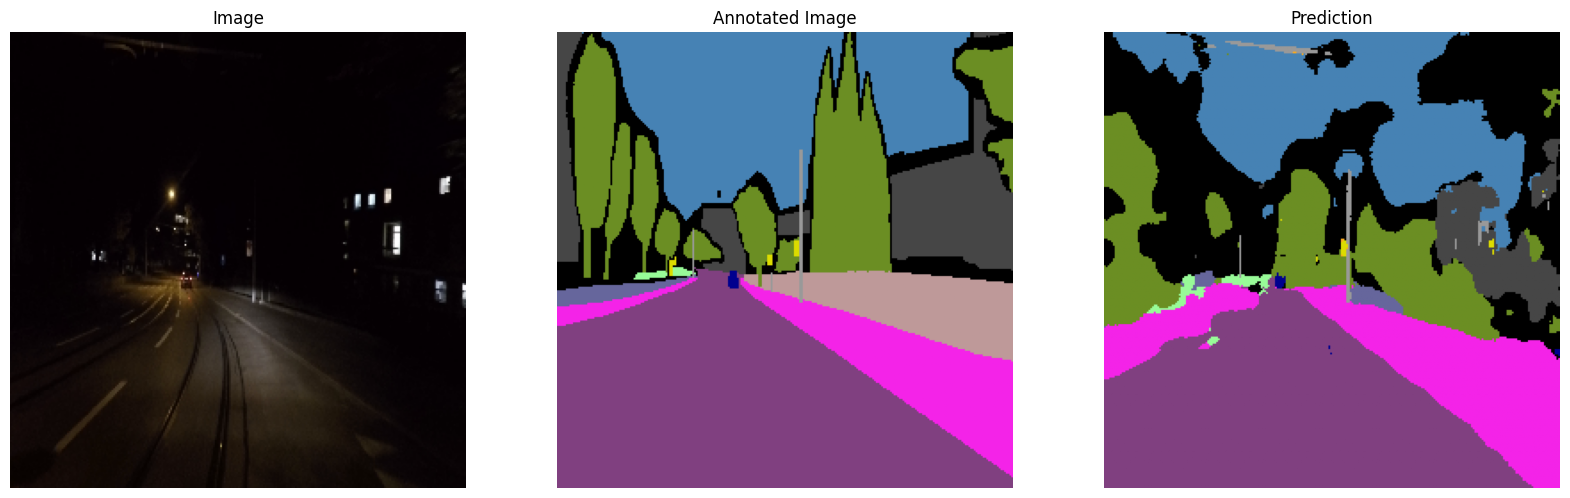

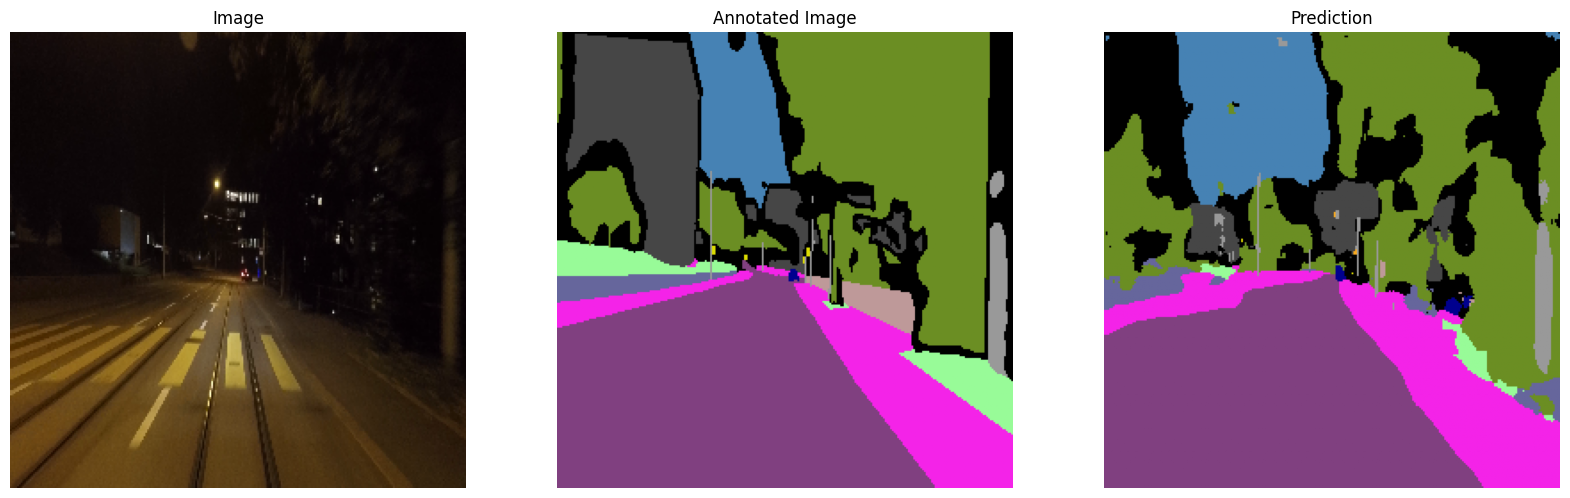

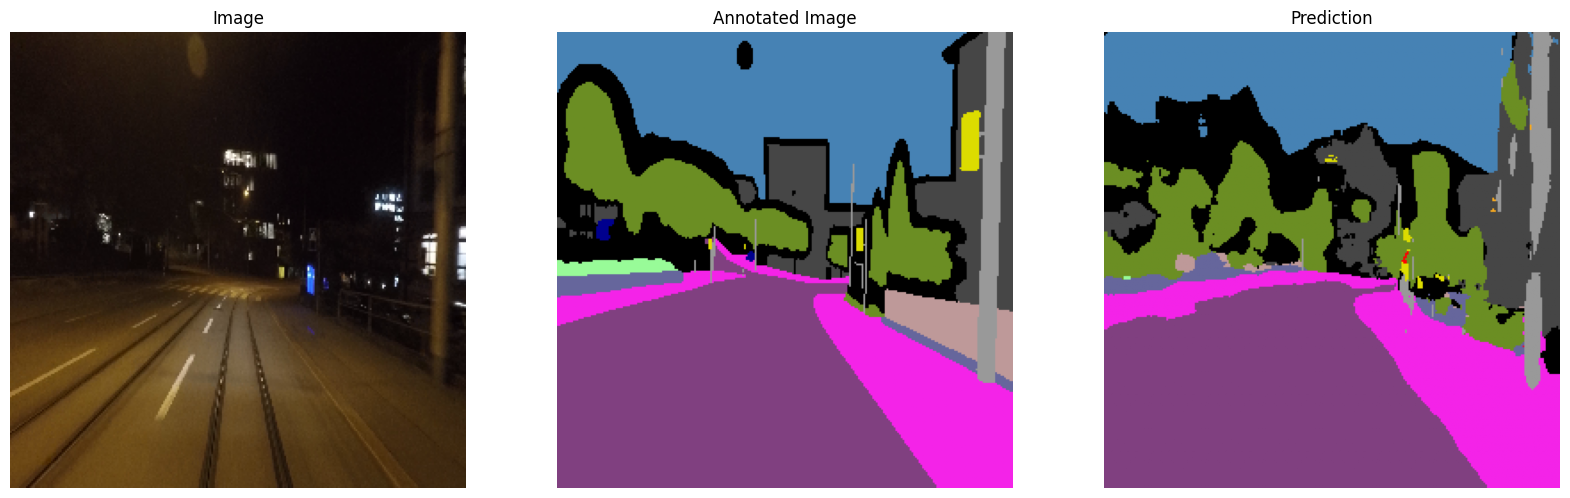

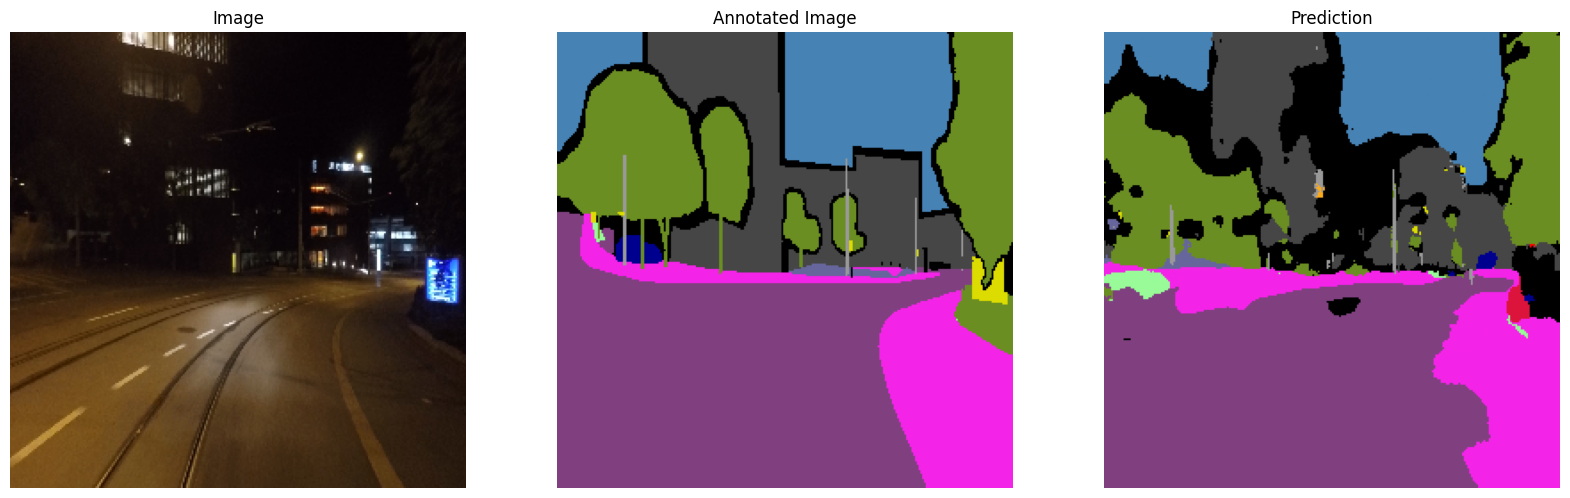

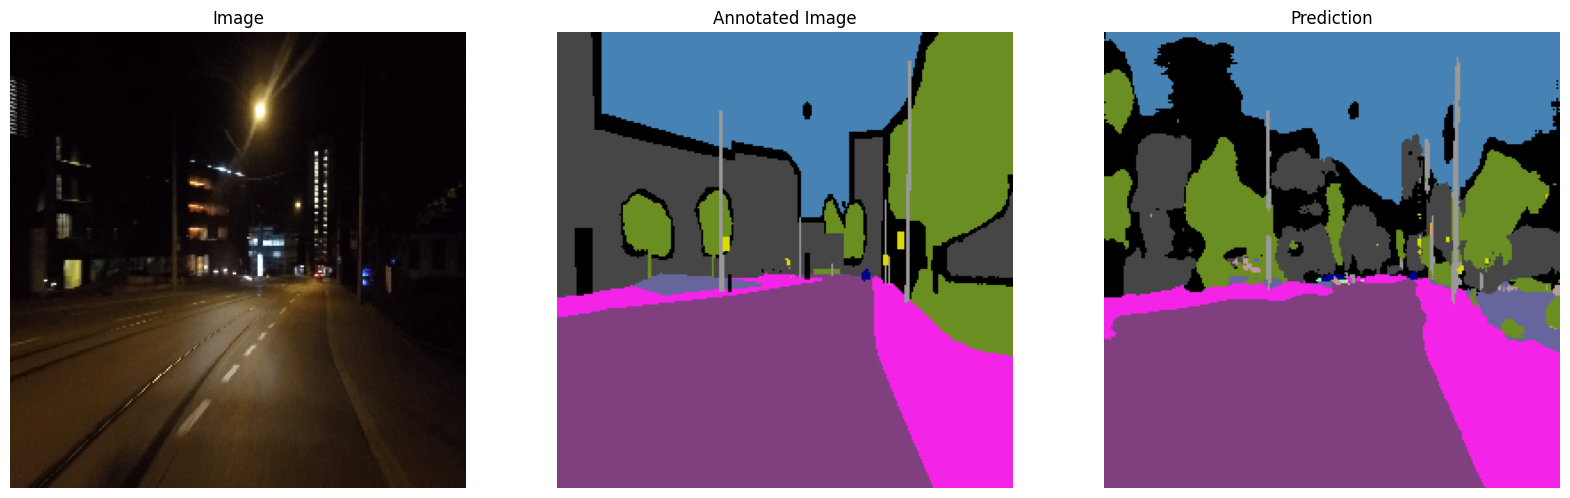

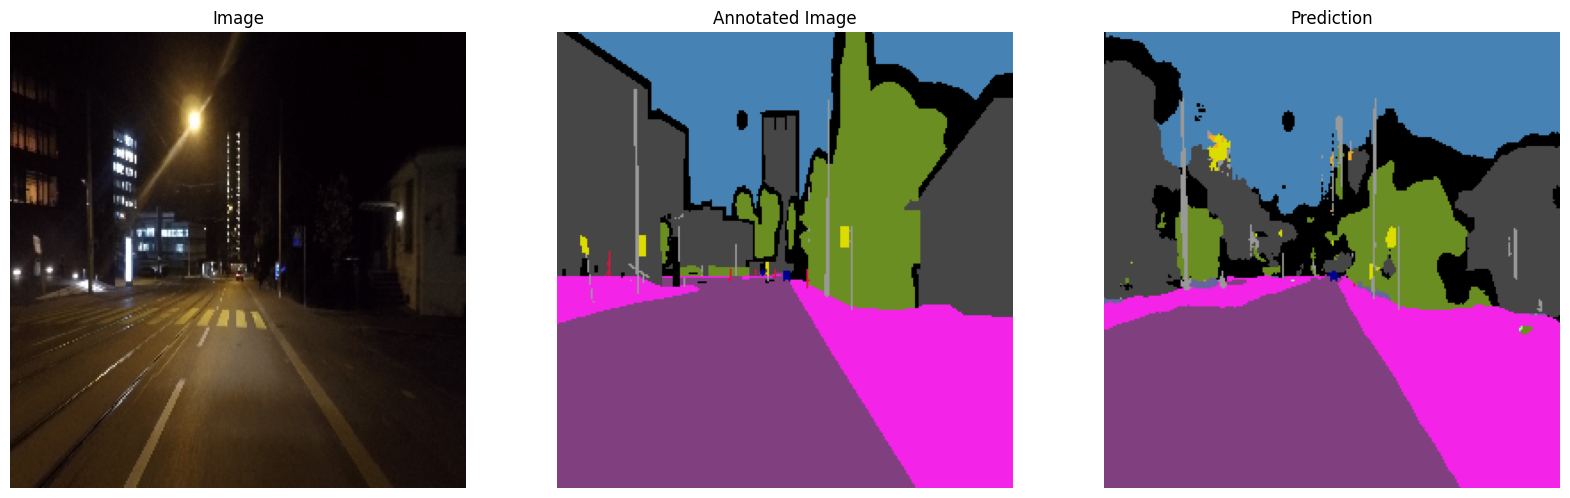

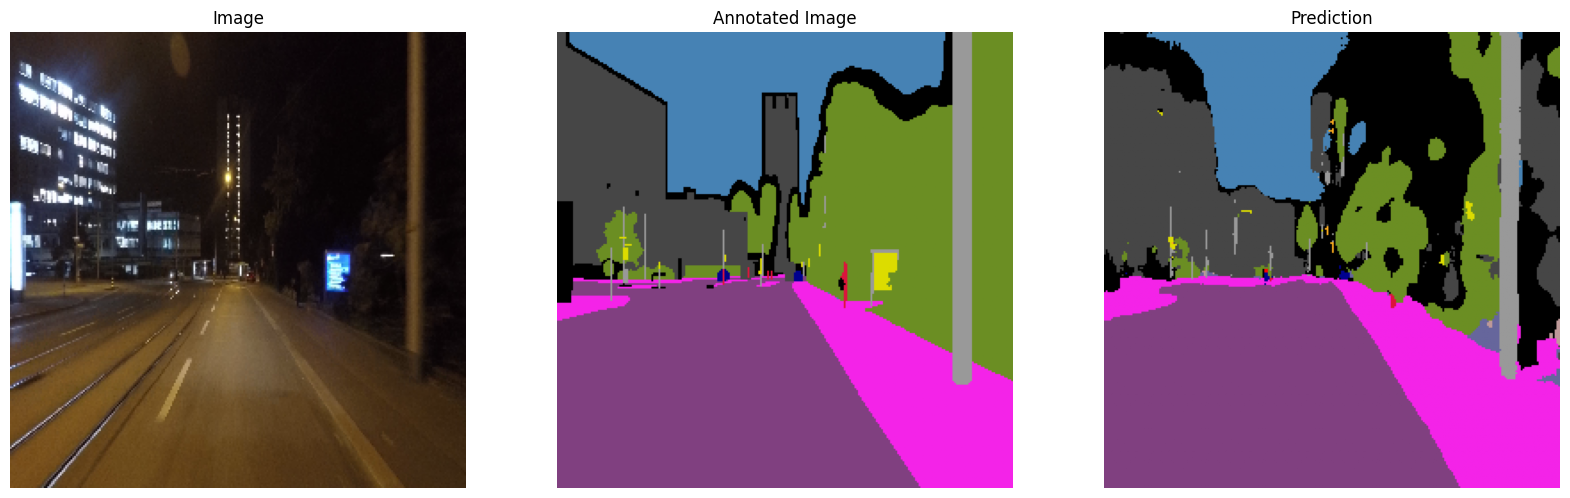

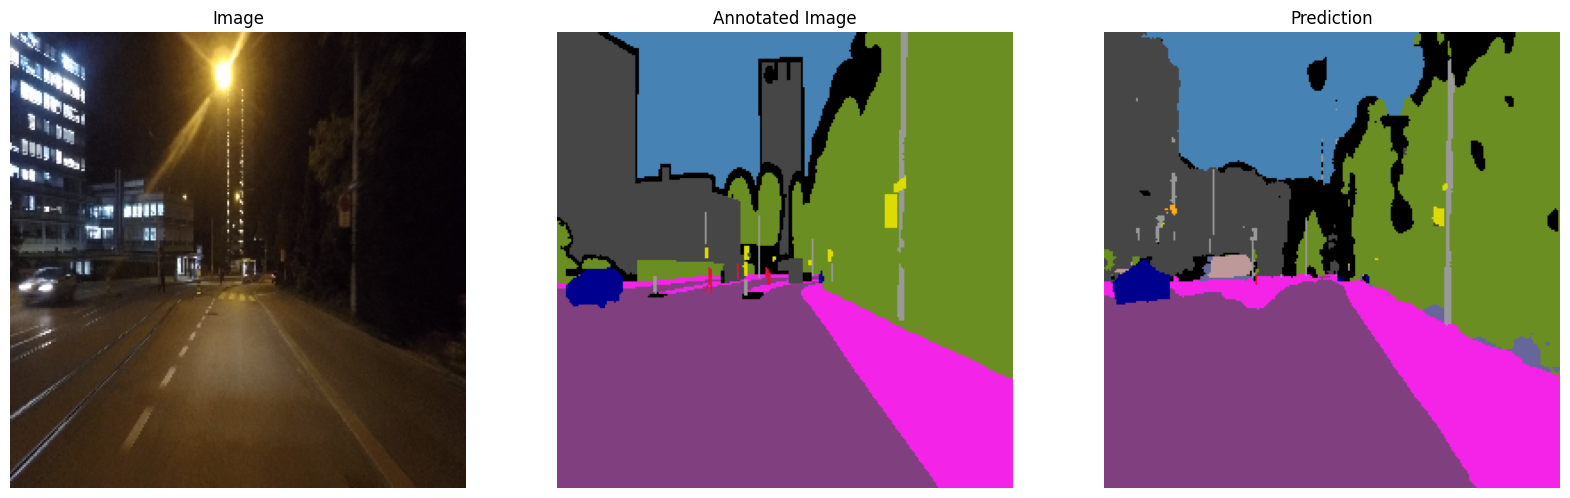

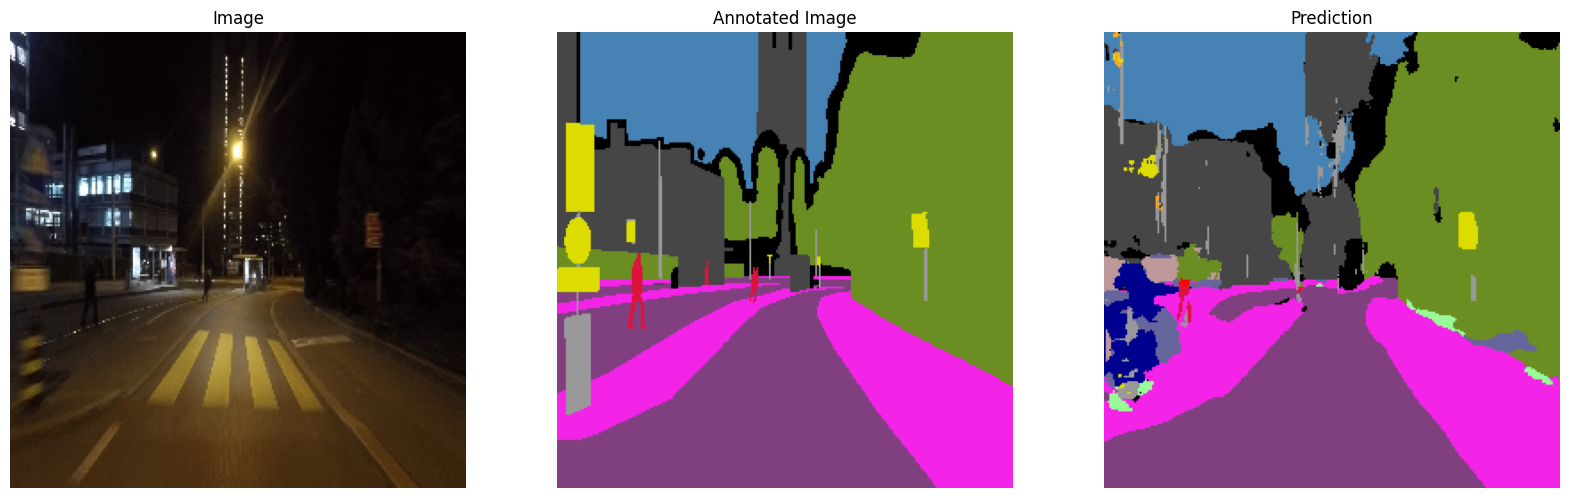

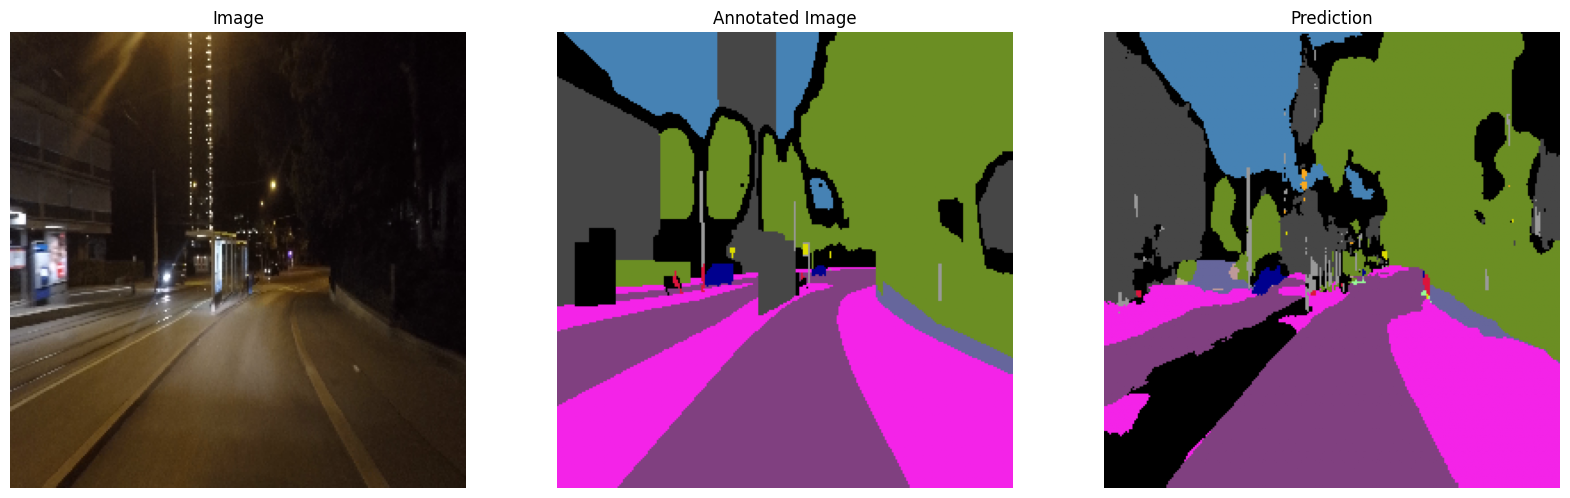

In [24]:
for x in range(0, 10):
    prediction.predict(validation_duo[x])

(WindowsPath('../../../Project/Dataset/Fog/RGB/Fog_Validation/GOPR0476_frame_000761_rgb_anon.png'), WindowsPath('../../../Project/Dataset/Fog/Annotated/Validation/GOPR0476_frame_000761_gt_labelColor.png'))


NameError: name 'Path' is not defined